------------------------------------------------------------------------------------------
# **Movie Recommendation using Graph Neural Networks**
-------------------------------------------------------------------------------------

## **Context**
Online streaming platforms like Netflix have plenty of movies in their repositories and if we can build a recommendation system to recommend relevant movies to users based on their historical interactions, this would improve customer satisfaction and hence improve revenue. The techniques that we will learn here will not only be limited to movies, they can be implemented through a Graph Neural Networks for other problems as well.

## **Objective**

In this case study, we will be building a graph neural network (GNN) to suggest similar movies based on what movies a user has watched.

## **Dataset**

The 'ratings' dataset contains the following attributes:
- userId
- movieId
- rating
- timestamp

We will also use the 'movies' dataset to get the title of the movies. It contains the following attributes:

- movieId
- title
- genres

## **Importing the necessary libraries**

In [1]:
import os

from collections import defaultdict

import math

import networkx as nx

import random

from tqdm import tqdm

from zipfile import ZipFile

from urllib.request import urlretrieve

import numpy as np

import pandas as pd

import tensorflow as tf

from tensorflow import keras

from tensorflow.keras import layers

import matplotlib.pyplot as plt

## **Retrieving the Datasets from the URL**

In [2]:
urlretrieve(
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip", "movielens.zip"
)

ZipFile("movielens.zip", "r").extractall()

## **Converting the datasets into more readable format**

In [3]:
# Load movies to a DataFrame

movies = pd.read_csv("ml-latest-small/movies.csv")

# Create a `movieId` string

movies["movieId"] = movies["movieId"].apply(lambda x: f"movie_{x}")

# Load ratings to a DataFrame

ratings = pd.read_csv("ml-latest-small/ratings.csv")

# Convert the `ratings` to floating point

ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

# Create the `movie_id` string

ratings["movieId"] = ratings["movieId"].apply(lambda x: f"movie_{x}")

print("Movies data shape:", movies.shape)

print("Ratings data shape:", ratings.shape)

Movies data shape: (9742, 3)
Ratings data shape: (100836, 4)


In [4]:
# This function gives us the name of the movie from the movieId
def get_movie_title_by_id(movieId):

    return list(movies[movies.movieId == movieId].title)[0]

# This function gives us the id of the movie from the name of the movie
def get_movie_id_by_title(title):

    return list(movies[movies.title == title].movieId)[0]

In [5]:
# Let's look at the datasets
ratings.head()

,userId,movieId,rating,timestamp
0,1,movie_1,4.0,964982703
1,1,movie_3,4.0,964981247
2,1,movie_6,4.0,964982224
3,1,movie_47,5.0,964983815
4,1,movie_50,5.0,964982931


In [6]:
movies.head()

,movieId,title,genres
0,movie_1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,movie_2,Jumanji (1995),Adventure|Children|Fantasy
2,movie_3,Grumpier Old Men (1995),Comedy|Romance
3,movie_4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,movie_5,Father of the Bride Part II (1995),Comedy


## **Calculating Pairwise and Item Frequency**

Let's calculate item_frequency for each movie and pair_frequency for every possible pair of movies. We need these frequencies to build our Graph. The purpose of these frequencies is written below.

In [7]:
min_rating = 5

item_frequency = defaultdict(int)  # Dictionary to indicate how many times each movie has been watched

pair_frequency = defaultdict(int)  # Dictionary to indicate how many times a particular pair of movies have been watched

# Filter instances where the rating is greater than or equal to min_rating

rated_movies = ratings[ratings.rating >= min_rating]

# Group instances by the user. Here, each group contains movies watched by a particular user

movies_grouped_by_users = list(rated_movies.groupby("userId"))

for group in tqdm(

    movies_grouped_by_users,

    position = 0,

    leave = True,

    desc = "Compute movie rating frequencies",

):  # Iterating over all the groups

    # Get a list of movies rated by the user

    current_movies = list(group[1]["movieId"])

    for i in range(len(current_movies)):

        item_frequency[current_movies[i]] += 1  # Increasing count of item frequency for a particular movie on encountering it in a group

        for j in range(i + 1, len(current_movies)):

            x = min(current_movies[i], current_movies[j])

            y = max(current_movies[i], current_movies[j])

            pair_frequency[(x, y)] += 1  # Increasing count of pair frequency for a particular pair of movies on coming across it

Compute movie rating frequencies: 100%|██████████| 573/573 [00:00<00:00, 1141.78it/s]


In the cell above, we are creating two dictionaries:
- The first dictionary, i.e., 'item_frequency' is the item frequency where we calculate the number of times each movie has been watched, assuming every user has watched any particular movie exactly once.
- The second dictionary, i.e., 'pair_frequency' is the pair-wise frequency, where we see how many users have watched both of these movies.
- A greater value indicates higher probability of one of these movies being suggested when any new user has watched the other movie in the pair, i.e, if the pair-wise frequency of movie A and movie B is high, and a new user happens to watch movie A, they are likely to be suggested movie B.

## **Creating the Graph**

We are trying to model what movies are frequently watched together based on all of the user data. To think of this more intuitively, the higher the weight of an edge between two movies A and B, the higher is the probability of movie B being suggested after you have watched movie A and vice versa.

In [8]:
min_weight = 10

D = math.log(sum(item_frequency.values()))

# Create the undirected graph with the movies as nodes

movies_graph = nx.Graph()

# Add weighted edges between movies

# This automatically adds the movie nodes to the graph

for pair in tqdm(

    pair_frequency, position = 0, leave = True, desc = "Creating the movie graph"

):  # Iterating over every pair of movies
    x, y = pair  # Unpacking the tuple called 'pair' to receive the two movies


    xy_frequency = pair_frequency[pair]  # Pair-wise frequency of two particular movies

    x_frequency = item_frequency[x]  # Item frequency for the first movie in the pair

    y_frequency = item_frequency[y]  # Item frequency for the second movie in the pair

    # Calculating PMI index as a measure of the pairing strength

    pmi = math.log(xy_frequency) - math.log(x_frequency) - math.log(y_frequency) + D

    weight = pmi * xy_frequency

    # Only include edges with weight >= min_weight

    if weight >= min_weight:

        movies_graph.add_edge(x, y, weight = weight)  # Adding the edge to those particular nodes

Creating the movie graph: 100%|██████████| 298586/298586 [00:00<00:00, 571237.47it/s]


To calculate the pairing strength between two movies, we are using the PMI index. We could use some other measures and that is completely the programmer's choice.

So in our graph, our nodes are our movies and our edges are drawn based on the product of the PMI index and pair frequency for the two movies we are calculating the edge weight for. If this value exceeds our minimum weight (which is a hyperparameter defined by us, in this case, equal to 10) we draw an edge with the calculated weight.

In [9]:
print("Total number of graph nodes:", movies_graph.number_of_nodes())

print("Total number of graph edges:", movies_graph.number_of_edges())

Total number of graph nodes: 1405
Total number of graph edges: 40043


## **Calculating Average Degree**

The average degree often gives us an idea about the inter-connectivity of the nodes. Let's see how we can interpret the result.

In [10]:
degrees = []

for node in movies_graph.nodes:

    degrees.append(movies_graph.degree[node])

print("Average node degree:", round(sum(degrees) / len(degrees), 2))

Average node degree: 57.0


This average degree comes out to be 57 when we are taking the minimum weight to be 10. This gives us an idea that on average every node is connected to 57 other nodes. To look at it intuitively, this gives us the assurance that every movie would have suggestions for what to watch next.

## **Creating Vocabulary lookup for Embedding**

In [11]:
vocabulary = ["NA"] + list(movies_graph.nodes)

vocabulary_lookup = {token: idx for idx, token in enumerate(vocabulary)}

## **Traversing through our Graph: To pick the next node among all neighbors**

The function 'next_step()' does the simple operation of traveling to the next node given you’re currently on a node, i.e., when you have watched a movie, what are the next movies you could consider.

In [12]:
def next_step(graph, previous, current, p, q):

    neighbors = list(graph.neighbors(current))

    weights = []

    # Adjust the weights of the edges to the neighbors with the help of p and q so that we can control or give a preference to which category of nodes we would want to visit next

    for neighbor in neighbors: # Looping through all the neighbors

        if neighbor == previous:

            # Control the probability to return to the previous node

            weights.append(graph[current][neighbor]["weight"] / p)

        elif graph.has_edge(neighbor, previous):

            # The probability of visiting a local node

            weights.append(graph[current][neighbor]["weight"])

        else:

            # Control the probability to move forward

            weights.append(graph[current][neighbor]["weight"] / q)

    # Compute the probabilities of visiting each neighbor

    weight_sum = sum(weights)

    probabilities = [weight / weight_sum for weight in weights]

    # Probabilistically select a neighbor to visit

    next = np.random.choice(neighbors, size = 1, p = probabilities)[0]

    return next

Since each node in the graph is likely to have more than one neighbor (judging from the average degree, which was 57), we have to take a probabilistic approach. In other words, since we have more than one option for the next step, we assign probabilities to each edge arising from our current node/movie, and then we make our random choice based on those probabilities.

Now here we have two hyperparameters, p and q, through which we can modify the probabilities a little. The value of q should lie between 1 and p. This is because the probability of visiting a node that has an edge with the current node as well as an edge with a previous node should be the greatest. The probability of a node that has an edge with the current node but not with the previous node should be lesser than the previous case. The probability of re-visiting this node should be the least. Therefore 1>q>p should be kept in mind while playing with these hyperparameters.

## **Creating Walks across our Graph**

We want to generate sequences of movies that are connected with each other through edges inside the graph. These sequences can be later used to generate training data for training our Neural Network.

In [13]:
def random_walk(graph, num_walks, num_steps, p, q):

    walks = []

    nodes = list(graph.nodes())

    # Perform multiple iterations of the random walk

    for walk_iteration in range(num_walks):

        random.shuffle(nodes)

        for node in tqdm(

            nodes,

            position = 0,

            leave = True,

            desc = f"Random walks iteration {walk_iteration + 1} of {num_walks}",
        ):
            # Start the walk with a random node from the graph

            walk = [node]

            # Randomly walk for num_steps by calling the next_step function we created above

            while len(walk) < num_steps:

                current = walk[-1]  # Current node is the last element of the array 'walk'

                previous = walk[-2] if len(walk) > 1 else None  # If the length of our array 'walk' is more than one, then the previous node is the second last element of the array 'walk'

                next = next_step(graph, previous, current, p, q)  # Compute the next node to visit

                walk.append(next)  # Append the next node obtained to the array 'walk'

            # Replace node ids (movieId) in the walk with token ids by looking at the vocabulary lookup

            walk = [vocabulary_lookup[token] for token in walk]

            # Add the walk to the generated sequence

            walks.append(walk)

    return walks

This function has been created to create random walks with each walk having the number of movies defined by the num_steps argument. After we get each walk, we append them to an array, which we will use for generating our data for training the neural network through the generate_examples( ) function.

## **Setting Hyperparameters for traversing through the Graph**

In [14]:
# Random walk return parameter

p = 2

# Random walk in-out parameter

q = 1.5

# Number of iterations of random walks

num_walks = 5

# Number of steps of each random walk

num_steps = 10

walks = random_walk(movies_graph, num_walks, num_steps, p, q)

print("Number of walks generated:", len(walks))

Random walks iteration 5 of 5: 100%|██████████| 1405/1405 [00:04<00:00, 293.42it/s]

Number of walks generated: 7025


We have set the value of p to 2, and q should lie between 1 and p. So we have chosen its value as 1.5. We can try out various combinations for these hyperparameters and check their result.

## **Generating Pairs of Movies that should have closer Embeddings**

In the generate_examples( ) function, we use the skipgram function, which creates positive and negative samples. To get an intuition about positive and negative samples, please refer to the walkthrough document.

In [15]:
def generate_examples(sequences, window_size, num_negative_samples, vocabulary_size):

    example_weights = defaultdict(int)

    # Iterate over all sequences (walks)

    for sequence in tqdm(

        sequences,

        position = 0,

        leave = True,

        desc = f"Generating postive and negative examples",
    ):

        # Generate positive and negative skipgram pairs for a sequence or walk

        pairs, labels = keras.preprocessing.sequence.skipgrams(

            sequence,

            vocabulary_size = vocabulary_size,

            window_size = window_size,

            negative_samples = num_negative_samples,

        )
        for idx in range(len(pairs)):  # Iterating through all pairs received from the skipgram function

            pair = pairs[idx]  # Extracting the pair of movies

            label = labels[idx]  # Extracting the labels

            target, context = min(pair[0], pair[1]), max(pair[0], pair[1])

            if target == context:

                continue

            if(label == 1):  # If a positive sample is generated we label them 1, otherwise we label them 0

                previous_negative_label = 0

                previous_negative_entry = (target, context, previous_negative_label)

                example_weights[previous_negative_entry] = 0  # Making the previous entry of the negative sample equal to zero because we have a positive sample now

                entry = (target, context, label)

                example_weights[entry] += 1

            if(label == 0):  # If a negative sample is generated

                querylabel = 1

                queryentry = (target, context, querylabel)  # We check if a positive sample with the same pair of movies exist

                if ( example_weights[queryentry]>0):

                    continue  # We skip adding this entry to our entry if already a positive sample exists

                else:

                    entry = (target, context, label)

                    example_weights[entry] +=1  # If a positive sample doesn't exist, we add the negative example

    targets, contexts, labels, weights = [], [], [], []

    for entry in example_weights:

        weight = example_weights[entry]

        if(weight > 0):

            target, context, label = entry  # Tuple unpacking of the 'entry' tuple

            targets.append(target)

            contexts.append(context)

            labels.append(label)

            weights.append(weight)

    return np.array(targets), np.array(contexts), np.array(labels), np.array(weights)


num_negative_samples = 4

targets, contexts, labels, weights = generate_examples(

    sequences = walks,

    window_size = num_steps,

    num_negative_samples = num_negative_samples,

    vocabulary_size = len(vocabulary),

)

Generating postive and negative examples: 100%|██████████| 7025/7025 [00:12<00:00, 547.36it/s]


The above function generate_examples() calls skipgram function of keras.preprocessing. The skipgram function takes a corpus and generates pairs of words. If both words in the pair are a part of the corpus, we label them 1. Otherwise, we label them 0. Here our corpus is the array of random walks. So skipgram generates pairs of movies. If both of those movies have been present in a particular random walk, they are labeled as 1, otherwise 0.

In [16]:
print(f"Targets shape: {targets.shape}")

print(f"Contexts shape: {contexts.shape}")

print(f"Labels shape: {labels.shape}")

print(f"Weights shape: {weights.shape}")

Targets shape: (725550,)
Contexts shape: (725550,)
Labels shape: (725550,)
Weights shape: (725550,)


## **Generating Data in a Classification format for our Neural Network Training**

Our data needs to be in a particular format so that it fits our Neural network architecture inputs. Let's do that through these pre-processing activities.

In [17]:
batch_size = 1024

def create_dataset(targets, contexts, labels, weights, batch_size):

    inputs = {

        "target": targets,

        "context": contexts,

    }  # Pre-processing the targets, contexts, and labels vectors to fit our Neural Network pipeline

    dataset = tf.data.Dataset.from_tensor_slices((inputs, labels, weights))

    dataset = dataset.shuffle(buffer_size = batch_size * 2)  # Shuffling the data set to remove any chance of sequential data

    dataset = dataset.batch(batch_size, drop_remainder = True)

    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset


dataset = create_dataset(

    targets = targets,

    contexts = contexts,

    labels = labels,

    weights = weights,

    batch_size = batch_size,
)


The output of the generate_example gives us target, context, and label vectors. So from these three vectors, we create our own dataset for a classification task, where target and context movies would be our independent variables. And the label would be our dependent variable. And we build a Neural Network in a way so that it takes a look at the target movie and the context movie and it can predict the label value.

## **Hyperparameters for Neural Network Training**

In [18]:
learning_rate = 0.001

embedding_dim = 50

num_epochs = 10

## **Creating our Model**

Let's build a Neural Network Architecture which would take the target and context movie as input and try to predict the output label.

In [19]:
def create_model(vocabulary_size, embedding_dim):

    inputs = {

        "target": layers.Input(name = "target", shape = (), dtype = "int32"),

        "context": layers.Input(name = "context", shape = (), dtype = "int32"),

    }
    # Initialize item embeddings

    embed_item = layers.Embedding(

        input_dim = vocabulary_size,

        output_dim = embedding_dim,

        embeddings_initializer = "he_normal",

        embeddings_regularizer = keras.regularizers.l2(1e-6),

        name="item_embeddings",
    )

    # Lookup embeddings for the target

    target_embeddings = embed_item(inputs["target"])

    # Lookup embeddings for the context

    context_embeddings = embed_item(inputs["context"])

    # Compute dot similarity between target and context embeddings

    logits = layers.Dot(axes = 1, normalize = False, name = "dot_similarity")(

        [target_embeddings, context_embeddings]
    )

    # Create the model

    model = keras.Model(inputs = inputs, outputs = logits)

    return model

This model is fairly simple. There is an Embedding layer that converts the target and context to target embeddings and context embeddings, respectively. Then we take the dot product of these two embeddings to get an output on the scale of 0 to 1. This way it tries to train with the training data.

In [20]:
model = create_model(len(vocabulary), embedding_dim)

model.compile(
    optimizer = keras.optimizers.Adam(learning_rate),

    loss = keras.losses.BinaryCrossentropy(from_logits = True),

)  # Setting up the model's optimizers

In [21]:
!pip install pydot

## **Visualizing the Model**

Keras comes with an in-built visualization tool. Let's use that and visualize our architecture.

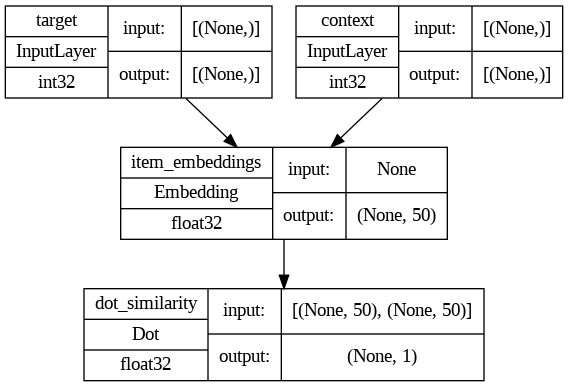

In [22]:
keras.utils.plot_model(

    model, show_shapes = True, show_dtype = True, show_layer_names = True,
)


## **Training Phase**

In [23]:
history = model.fit(dataset, epochs = num_epochs)

Epoch 1/10
708/708 [==============================] - 6s 7ms/step - loss: 2.1143
Epoch 2/10
708/708 [==============================] - 9s 13ms/step - loss: 1.7572
Epoch 3/10
708/708 [==============================] - 10s 14ms/step - loss: 1.6860
Epoch 4/10
708/708 [==============================] - 11s 16ms/step - loss: 1.6564
Epoch 5/10
708/708 [==============================] - 6s 8ms/step - loss: 1.6370
Epoch 6/10
708/708 [==============================] - 6s 8ms/step - loss: 1.6222
Epoch 7/10
708/708 [==============================] - 5s 7ms/step - loss: 1.6092
Epoch 8/10
708/708 [==============================] - 6s 8ms/step - loss: 1.5960
Epoch 9/10
708/708 [==============================] - 5s 7ms/step - loss: 1.5814
Epoch 10/10
708/708 [==============================] - 5s 7ms/step - loss: 1.5654


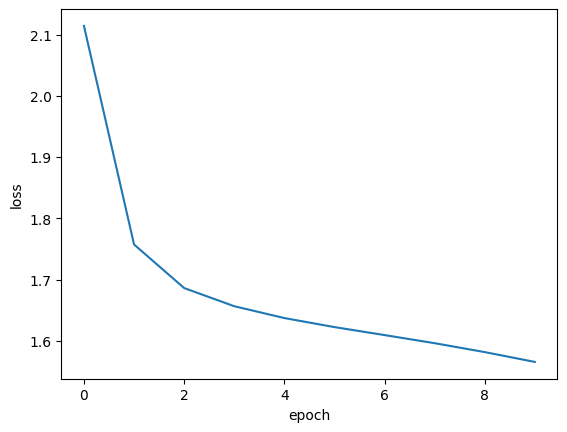

In [24]:
plt.plot(history.history["loss"])

plt.ylabel("loss")

plt.xlabel("epoch")

plt.show()

## **Extracting the Embedding Vector**

In [25]:
movie_embeddings = model.get_layer("item_embeddings").get_weights()[0]  # Extracting the layer weight by layer name

print("Embeddings shape:", movie_embeddings.shape)

Embeddings shape: (1406, 50)


We had created a self-supervised task and now we take out the embedding vectors so that we can directly check for similarity among any two movies after they are converted to their particular movie_id by the get_movie_id_by_title().

In [26]:
query_movies = [

    "Matrix, The (1999)",

    "Star Wars: Episode IV - A New Hope (1977)",

    "Lion King, The (1994)",

    "Terminator 2: Judgment Day (1991)",

    "Godfather, The (1972)",
]

## **Converting Query movies to Query Embeddings**

In [27]:
query_embeddings = []

for movie_title in query_movies:

    movieId = get_movie_id_by_title(movie_title)  # Getting id from the title of the movie

    token_id = vocabulary_lookup[movieId]  # Getting index to lookup for embedding task

    movie_embedding = movie_embeddings[token_id]  # Getting embedding for query movies

    query_embeddings.append(movie_embedding)

query_embeddings = np.array(query_embeddings)

## **Finding the top 5 similar Embeddings**

In [28]:
similarities = tf.linalg.matmul(

    tf.math.l2_normalize(query_embeddings),  # Normalizing the results of multiplication to get output of dot product on a scale of 0 to 1

    tf.math.l2_normalize(movie_embeddings),

    transpose_b = True,
)

_, indices = tf.math.top_k(similarities, k = 5)

indices = indices.numpy().tolist()

## **Converting those top 5 Embeddings to Movie titles**

In [29]:
for idx, title in enumerate(query_movies):

    print(title)

    print("".rjust(len(title), "-"))

    similar_tokens = indices[idx]

    for token in similar_tokens:

        similar_movieId = vocabulary[token]

        similar_title = get_movie_title_by_id(similar_movieId)

        print(f"- {similar_title}")

    print()

Matrix, The (1999)
------------------
- Matrix, The (1999)
- Star Wars: Episode IV - A New Hope (1977)
- Pulp Fiction (1994)
- Terminator 2: Judgment Day (1991)
- Fight Club (1999)

Star Wars: Episode IV - A New Hope (1977)
-----------------------------------------
- Star Wars: Episode IV - A New Hope (1977)
- Star Wars: Episode VI - Return of the Jedi (1983)
- Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
- Terminator 2: Judgment Day (1991)
- Star Wars: Episode V - The Empire Strikes Back (1980)

Lion King, The (1994)
---------------------
- Lion King, The (1994)
- Braveheart (1995)
- Aladdin (1992)
- Jurassic Park (1993)
- Fugitive, The (1993)

Terminator 2: Judgment Day (1991)
---------------------------------
- Terminator 2: Judgment Day (1991)
- Braveheart (1995)
- Fugitive, The (1993)
- Star Wars: Episode VI - Return of the Jedi (1983)
- Forrest Gump (1994)

Godfather, The (1972)
---------------------
- Godfather, The (1972)
- Casablanca (1942)
- 

## **Conclusion**

- We have converted our user data which had ratings for movies to a self-supervised task of training an embedding vector, which is ultimately helping us in suggesting top 'k' similar movies for a particular.
- We have used techniques of random walks and skipgram models to generate examples of pairs of similar nodes that help in node embedding.
- We have used a graph neural network to solve a recommendation problem.